In [328]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from nistats import design_matrix
import scipy.stats as ss
import statsmodels.api as sm

In [359]:
df = pd.read_pickle('/Users/gdehol/git/nddm_simulations/notebooks/data/simulated_data.pkl')

df['onset'] = np.arange(10, len(df)*20 + 1, 20) + np.random.exponential(4, size=len(df))

## Simulation function

In [360]:
from nistats import hemodynamic_models
def get_bold_response(df, method='time_on_task',
                      cue_delay=None,
                      noise=0.0,
                      sample_rate=1000):
    
    neural_signal = np.zeros(int((df.onset.max() + 20) * sample_rate))
    
#     hrf = nipy.modalities.fmri.hrf.spm_hrf_compat(np.arange(0, 20, 1./sample_rate))
    hrf = hemodynamic_models.spm_hrf(1./sample_rate, oversampling=1, time_length=20.)
    
    for ix, row in df.iterrows():
        
        if method == 'time_on_task':
            start_idx = int(row.onset * sample_rate)
            end_idx = int((row.onset + row.rt)*sample_rate)
            value = 1
            
        elif method == 'time_on_task_drift':
            start_idx = int(row.onset * sample_rate)
            end_idx = int((row.onset + row.rt)*sample_rate)
            value = row.drift  
            
            
        elif method == 'drift':
            start_idx = int(row.onset * sample_rate)
            end_idx = int(start_idx + .35 *sample_rate)            
            value = row.drift              
            
        elif method == 'error_monitoring': 
            feedback_delay = np.random.choice([.200, .700, 1.200, 1.700])            
            start_idx = int((row.onset + row.rt+feedback_delay)*sample_rate)
            end_idx = int(start_idx + .35 *sample_rate)            
            value =  1.5  - row.accuracy
            
        elif method == 'motor_response':
            start_idx = int((row.onset + row.rt)*sample_rate)
            end_idx = int(start_idx + .35 *sample_rate)            
            value =  1.           
        
        if cue_delay is None:        
            neural_signal[start_idx:end_idx] = value
        else:            
            offset = np.random.choice(cue_delay) * sample_rate            
            neural_signal[start_idx+offset:end_idx+offset] = value
            
        
    
    bold_signal = np.convolve(hrf, neural_signal) 
    bold_signal += ss.norm.rvs(size=len(bold_signal)) * noise
    
    return neural_signal, bold_signal
    

## Simulations

We're going to do 4 simulations:

 * TR=2.0, no noise
 * TR=2.0, noise = 1
 * TR=2.0, no noise, regress out error +  RTs
 * TR=2.0, noise = 1, regress out error +  RTs 


In [361]:
TR = 2.0
sample_rate = 1/TR

### Simple Design Matrix

In [362]:
onsets = pd.DataFrame()
onsets['trial_type'] = ['trial %d' % (ix) for ix in df.index.get_level_values('trial')]
onsets['duration'] = 0.0
onsets['onset'] = df.onset.values
onsets['accuracy'] = df.accuracy.values
onsets['rt'] = df.rt.values

n_scans = int((df.onset.max() + 20) * sample_rate)
frametimes = np.linspace(0, (n_scans - 1) * tr, n_scans)


X1 = design_matrix.make_first_level_design_matrix(frametimes, onsets, oversampling=10, drift_model=None, )

In [363]:
# onsets['modulation'] = 1.0
onsets['duration'] = onsets['rt']

errors = onsets[onsets.accuracy == 0.0].copy()
errors['trial_type'] = 'error'

# onsets = onsets.append(errors)

X2 = design_matrix.make_first_level_design_matrix(frametimes, onsets, oversampling=50, drift_model=None)

# def regress_out(y, x):    
#     return sm.OLS(y, x).fit().resid

# for trial in range(1, 26):
#     X2[f'trial {trial}'] = regress_out(X2[f'trial {trial}'], X2[['error', 'rt_regressor']])
    
X2 = X2.drop('constant', 1)

In [407]:
results = []

for noise in [0.0, .1]:
    for x, X in enumerate([X1, X2]):
        for method in ['time_on_task', 'time_on_task_drift', 'drift', 'error_monitoring', 'motor_response']:
            neural_signal, bold_signal = get_bold_response(df, sample_rate=sample_rate*100, method=method, noise=noise*10.)

            bold_signal = signal.resample_poly(bold_signal, 1, 100)
            bold_signal = bold_signal[:n_scans]
            bold_signal -= bold_signal.mean()
            frametimes = np.linspace(0, (n_scans - 1) * tr, n_scans)

            model = sm.OLS(bold_signal, X)

            r = model.fit()

            single_trial_betas = r.params.to_frame('beta')
            single_trial_betas.index.name = 'trial'
            single_trial_betas = single_trial_betas.reset_index()
            single_trial_betas['trial'] = single_trial_betas.trial.apply(lambda x: int(x[5:]) if x[:5] == 'trial' else np.nan)

            single_trial_betas['method'] = method
            single_trial_betas['design matrix'] = x
            single_trial_betas['noise'] = noise

            single_trial_betas = df.merge(single_trial_betas, on='trial')

            results.append(single_trial_betas)

/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


In [408]:
results = pd.concat(results)

/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

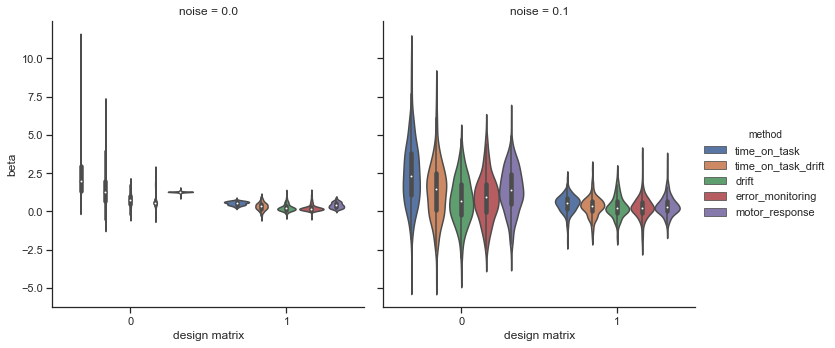

In [409]:
sns.catplot('design matrix', 'beta', 'method', data=results.reset_index(), kind='violin', col='noise')

In [410]:
results.set_index(['method', 'design matrix', 'noise', 'trial']).unstack('noise')

drift           drift_trialmu       \
noise                                        0.0       0.1           0.0  0.1   
method             design matrix trial                                          
drift              0             1      0.695444  0.695444           0.6  0.6   
                                 2      0.305807  0.305807           0.6  0.6   
                                 3      0.751351  0.751351           0.6  0.6   
                                 4      0.510613  0.510613           0.6  0.6   
                                 5      0.429158  0.429158           0.6  0.6   
...                                          ...       ...           ...  ...   
time_on_task_drift 1             296    0.607530  0.607530           0.6  0.6   
                                 297    0.301401  0.301401           0.6  0.6   
                                 298    0.461191  0.461191           0.6  0.6   
                                 299    0.732916  0.732916           0.6  0.6   
                                 300    0.613085  0.613085           0.6  0.6   

                                       drift_trialsd         rel_sp            \
noise                                            0.0  0.1       0.0       0.1   
method             design matrix trial                                          
drift              0             1               0.3  0.3  0.625940  0.625940   
                                 2               0.3  0.3  0.468294  0.468294   
                                 3               0.3  0.3  0.551870  0.551870   
                                 4               0.3  0.3  0.596632  0.596632   
                                 5               0.3  0.3  0.564902  0.564902   
...                                              ...  ...       ...       ...   
time_on_task_drift 1             296             0.3  0.3  0.615137  0.615137   
                                 297             0.3  0.3  0.494512  0.494512   
                                 298             0.3  0.3  0.477128  0.477128   
                                 299             0.3  0.3  0.498241  0.498241   
                                 300             0.3  0.3  0.548067  0.548067   

                                       rel_sp_trialmu            ... accuracy  \
noise                                             0.0       0.1  ...      0.0   
method             design matrix trial                           ...            
drift              0             1           0.253347  0.253347  ...      0.0   
                                 2           0.253347  0.253347  ...      1.0   
                                 3           0.253347  0.253347  ...      1.0   
                                 4           0.253347  0.253347  ...      0.0   
                                 5           0.253347  0.253347  ...      1.0   
...                                               ...       ...  ...      ...   
time_on_task_drift 1             296         0.253347  0.253347  ...      0.0   
                                 297         0.253347  0.253347  ...      0.0   
                                 298         0.253347  0.253347  ...      1.0   
                                 299         0.253347  0.253347  ...      1.0   
                                 300         0.253347  0.253347  ...      1.0   

                                            accuracy_neg     accuracy_flipped  \
noise                                   0.1          0.0 0.1              0.0   
method             design matrix trial                                          
drift              0             1      0.0           -1  -1              1.0   
                                 2      1.0            1   1             -0.0   
                                 3      1.0            1   1             -0.0   
                                 4      0.0           -1  -1              1.0   
                                 5      1.0            1   1           

In [411]:
import seaborn as sns

/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

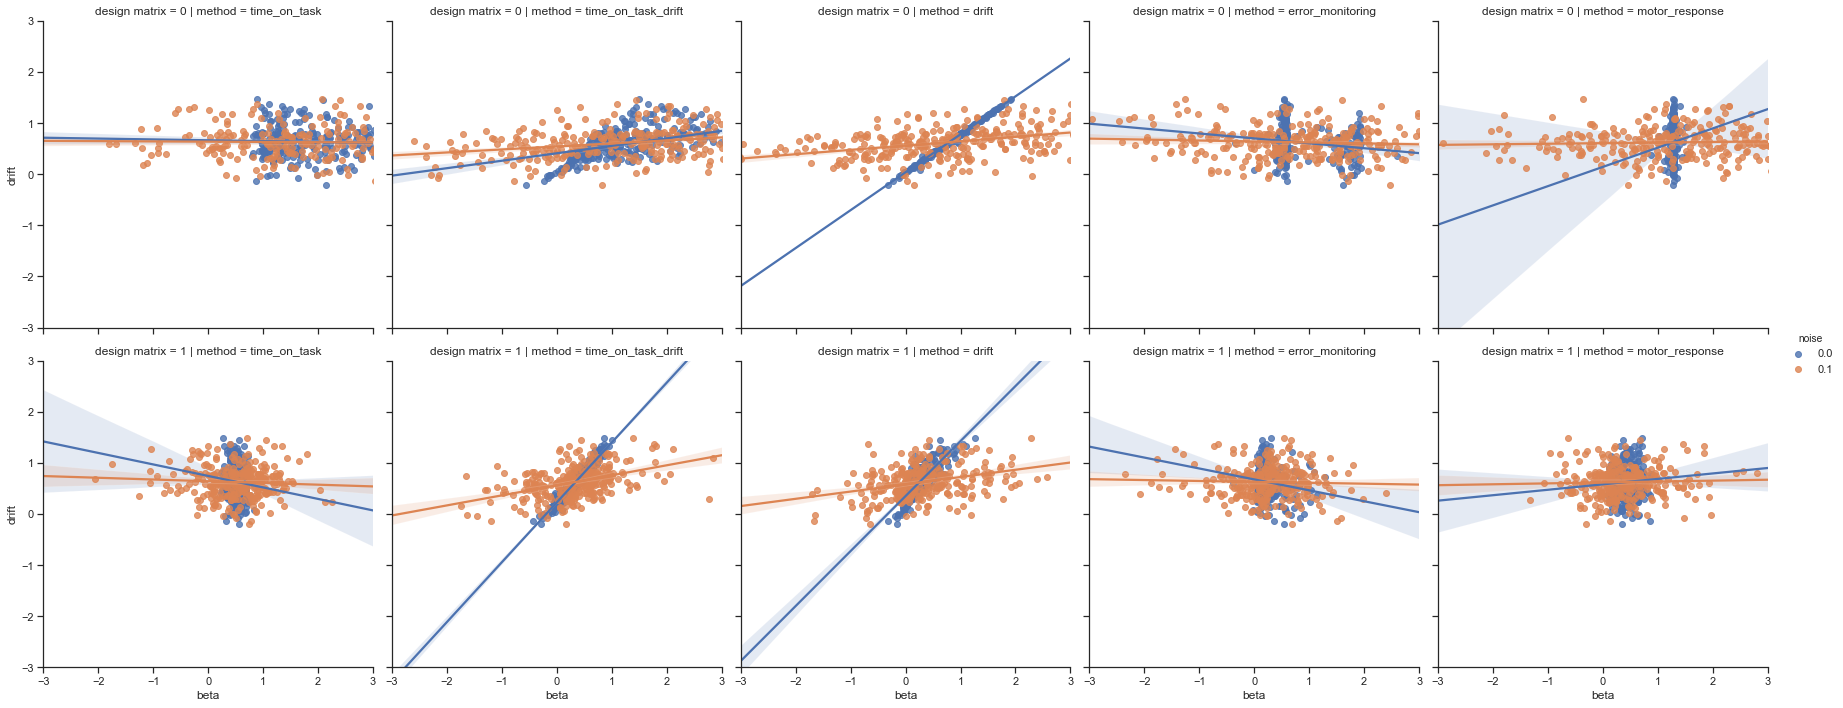

In [412]:
fac = sns.lmplot('beta', 'drift', hue='noise', data=results, col='method', row='design matrix')

fac.set(xlim=(-3, 3))
fac.set(ylim=(-3, 3))

/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

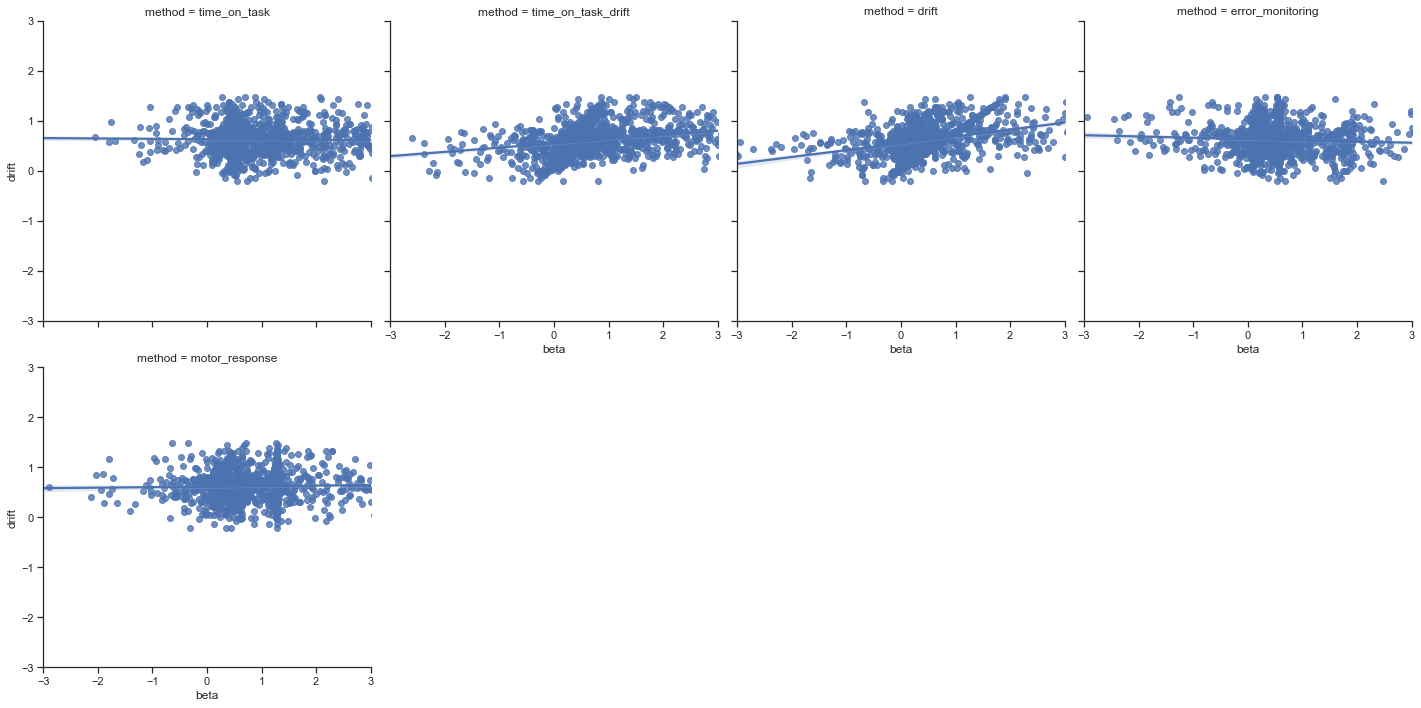

In [413]:
fac = sns.lmplot('beta', 'drift', data=results, col='method', col_wrap=4)

fac.set(xlim=(-3, 3))
fac.set(ylim=(-3, 3))

/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/gdehol/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is d

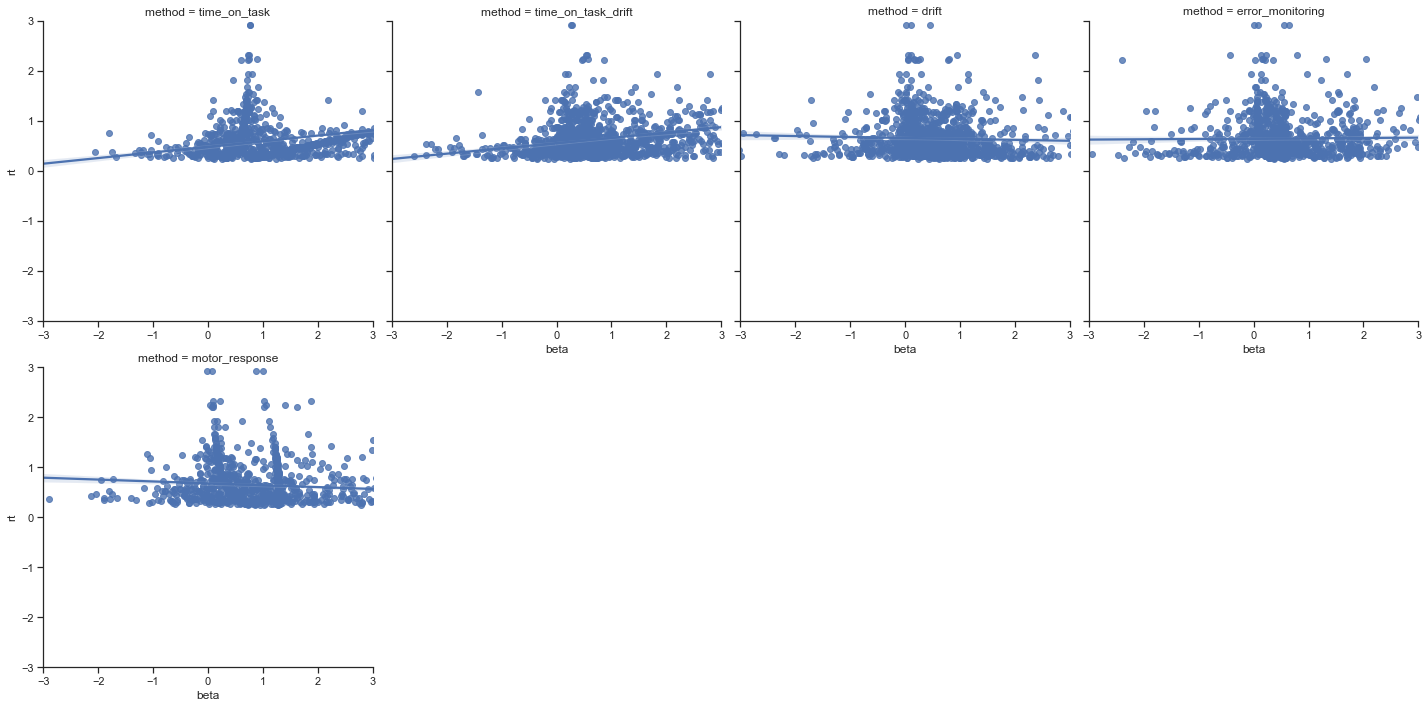

In [414]:
fac = sns.lmplot('beta', 'rt', data=results.reset_index(), col='method', col_wrap=4, sharex=False)

fac.set(xlim=(-3, 3))
fac.set(ylim=(-3, 3))

In [415]:
import pingouin

In [416]:
results.groupby('method').apply(lambda d: pingouin.corr(d['beta'], d['drift']))

,,n,r,CI95%,r2,adj_r2,p-val,BF10,power
method,,,,,,,,,
drift,pearson,1200,0.406,"[0.36, 0.45]",0.165,0.164,6.402272e-49,2.666e+45,1.000
error_monitoring,pearson,1200,-0.077,"[-0.13, -0.02]",0.006,0.004,7.367918e-03,1.305,0.765
motor_response,pearson,1200,0.033,"[-0.02, 0.09]",0.001,-0.001,2.592829e-01,0.068,0.204
time_on_task,pearson,1200,-0.038,"[-0.09, 0.02]",0.001,-0.000,1.870451e-01,0.086,0.262
time_on_task_drift,pearson,1200,0.356,"[0.31, 0.4]",0.126,0.125,4.462191e-37,4.567e+33,1.000


In [417]:
results

,trial,drift,drift_trialmu,drift_trialsd,rel_sp,rel_sp_trialmu,transf_rel_sp_trialmu,rel_sp_trialsd,threshold,ndt,rt,accuracy,accuracy_neg,accuracy_flipped,onset,beta,method,design matrix,noise
0,1,0.695444,0.6,0.3,0.625940,0.253347,0.6,0.3,1.4,0.23,0.993,0.0,-1,1.0,12.316868,3.817699,time_on_task,0,0.0
1,2,0.305807,0.6,0.3,0.468294,0.253347,0.6,0.3,1.4,0.23,0.363,1.0,1,-0.0,31.292479,1.286959,time_on_task,0,0.0
2,3,0.751351,0.6,0.3,0.551870,0.253347,0.6,0.3,1.4,0.23,1.100,1.0,1,-0.0,51.385172,4.222914,time_on_task,0,0.0
3,4,0.510613,0.6,0.3,0.596632,0.253347,0.6,0.3,1.4,0.23,0.767,0.0,-1,1.0,73.215657,2.935788,time_on_task,0,0.0
4,5,0.429158,0.6,0.3,0.564902,0.253347,0.6,0.3,1.4,0.23,0.571,1.0,1,-0.0,94.878718,2.130871,time_on_task,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,0.607530,0.6,0.3,0.615137,0.253347,0.6,0.3,1.4,0.23,1.129,0.0,-1,1.0,5917.341891,0.025951,motor_response,1,0.1
296,297,0.301401,0.6,0.3,0.494512,0.253347,0.6,0.3,1.4,0.23,0.493,0.0,-1,1.0,5934.584238,0.411406,motor_response,1,0.1
297,298,0.461191,0.6,0.3,0.477128,0.253347,0.6,0.3,1.4,0.23,0.443,1.0,1,-0.0,5951.979529,0.956856,motor_response,1,0.1
298,299,0.732916,0.6,0.3,0.498241,0.253347,0.6,0.3,1.4,0.23,0.680,1.0,1,-0.0,5976.425660,0.613630,motor_response,1,0.1


In [420]:
results = results.set_index(['method', 'design matrix', 'noise', 'trial'])

In [421]:
results.to_pickle('data/simulated_bold.pkl')

# Make illustrative HRF plots

In [422]:
tmp = df.loc[(slice(None), slice(3)), :].copy()
tmp['onset'] = 10, 30, 50

In [423]:
tmp['rt'] *= 3

In [425]:
sample_rate = 100

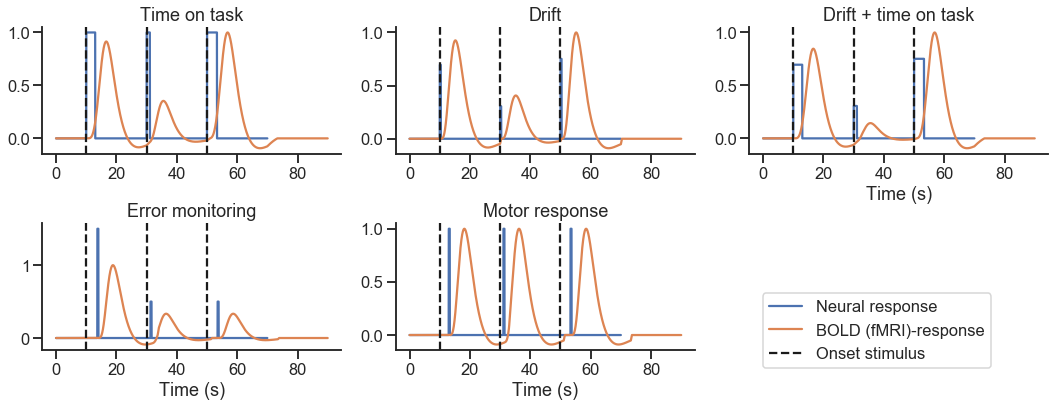

In [429]:
sns.set_context('talk')

plt.subplot(231)
plt.title('Time on task')
neural_signal, bold_signal = get_bold_response(tmp, sample_rate=sample_rate, method='time_on_task')

t = np.linspace(0, len(bold_signal) / sample_rate, len(bold_signal))
plt.plot(t[:len(neural_signal)], neural_signal)
plt.plot(t, bold_signal / bold_signal.max())
sns.despine()

for ix, row in tmp.iterrows():
    plt.axvline(row.onset, c='k', ls='--')
plt.gcf().set_size_inches(25, 4)


plt.subplot(232)
plt.title('Drift')
neural_signal, bold_signal = get_bold_response(tmp, sample_rate=sample_rate, method='drift')
plt.plot(t[:len(neural_signal)], neural_signal)
plt.plot(t, bold_signal / bold_signal.max())
sns.despine()
for ix, row in tmp.iterrows():
    plt.axvline(row.onset, c='k', ls='--')

plt.gcf().set_size_inches(15, 4)

plt.subplot(233)
plt.title('Drift + time on task')
neural_signal, bold_signal = get_bold_response(tmp, sample_rate=sample_rate, method='time_on_task_drift')
plt.plot(t[:len(neural_signal)], neural_signal)
plt.plot(t, bold_signal / bold_signal.max())
sns.despine()
plt.xlabel('Time (s)')
for ix, row in tmp.iterrows():
    plt.axvline(row.onset, c='k', ls='--')

plt.gcf().set_size_inches(15, 4)

plt.subplot(234)
plt.title('Error monitoring')
neural_signal, bold_signal = get_bold_response(tmp, sample_rate=sample_rate, method='error_monitoring')
plt.plot(t[:len(neural_signal)], neural_signal)
plt.plot(t, bold_signal / bold_signal.max())
sns.despine()
plt.xlabel('Time (s)')
for ix, row in tmp.iterrows():
    plt.axvline(row.onset, c='k', ls='--')

plt.gcf().set_size_inches(15, 4)


plt.subplot(235)
plt.title('Motor response')
neural_signal, bold_signal = get_bold_response(tmp, sample_rate=sample_rate, method='motor_response')
plt.plot(t[:len(neural_signal)], neural_signal, label='Neural signal')
plt.plot(t, bold_signal / bold_signal.max(), label='BOLD signal')
sns.despine()
plt.xlabel('Time (s)')
for ix, row in tmp.iterrows():
    plt.axvline(row.onset, c='k', ls='--', label='onset stimulus')

plt.gcf().set_size_inches(15, 6)
plt.tight_layout()

legend_x = 1.2
legend_y = 0.155
plt.legend(["Neural response", "BOLD (fMRI)-response", 'Onset stimulus'], loc='center left', bbox_to_anchor=(legend_x, legend_y))

# plt.tight_layout()

# # plt.gcf().subplots_adjust(right=1.15)

plt.savefig('data/hrf.png', transparent=True)